In [10]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import matplotlib

default_backend = matplotlib.get_backend()

# expected headers : len,world,iter,time

In [11]:
def plot(data, out_file, title, just_show):
    if not just_show:
        matplotlib.use("pgf")
        matplotlib.rcParams.update({
            "pgf.texsystem": "xelatex",
            'font.family': 'serif',
            'text.usetex': True,
            'pgf.rcfonts': False,
        })
    else:
        matplotlib.use(default_backend)

    data.plot(x="world", loglog=True, xticks = data['world'], ylabel='time(ms)', title=title)

    if just_show:
        plt.show()

    if not just_show:
        plt.savefig(out_file)

def process_scalar(cy, mod, dask, title, out_file, just_show = False):
    cylon_df = pd.read_csv(cy)
    modin_df = pd.read_csv(mod)
    dask_df = pd.read_csv(dask)

    cylon_avg = sqldf("SELECT world, avg(time) as avg FROM cylon_df GROUP BY world", locals())
    modin_avg = sqldf("SELECT world, avg(time) as avg FROM modin_df GROUP BY world", locals())
    dask_avg = sqldf("SELECT world, avg(time) as avg FROM dask_df GROUP BY world", locals())

    data = sqldf("""SELECT cy.world, cy.avg AS cylon, md.avg AS modin, da.avg as dask 
        FROM cylon_avg cy JOIN modin_avg md ON cy.world = md.world
        JOIN dask_avg da ON da.world = cy.world""", locals())

    plot(data, out_file, title, just_show)
    
def process_join(cy, mod, dask, title, out_file, len = 1000000, exclude_modin = False, just_show = False):
    cylon_df = pd.read_csv(cy)
    modin_df = pd.read_csv(mod)
    dask_df = pd.read_csv(dask)

    cylon_hash_avg = sqldf("SELECT world, avg(time) as avg FROM cylon_df WHERE tag like '%hash%' and len='"+str(len)+"' GROUP BY world", locals())
    cylon_sort_avg = sqldf("SELECT world, avg(time) as avg FROM cylon_df WHERE tag like '%sort%' and len='"+str(len)+"' GROUP BY world", locals())
    modin_avg = sqldf("SELECT world, avg(time) as avg FROM modin_df GROUP BY world", locals())
    dask_avg = sqldf("SELECT world, avg(time) as avg FROM dask_df WHERE len='"+str(len)+"' GROUP BY world", locals())

    if exclude_modin:
        data = sqldf("""SELECT cy.world, cy.avg AS cylon_hash, cys.avg as cylon_sort, da.avg as dask 
            FROM cylon_hash_avg cy 
            JOIN cylon_sort_avg cys ON cy.world = cys.world
            JOIN dask_avg da ON da.world = cy.world
            """, locals())
    else:
        data = sqldf("""SELECT cy.world, cy.avg AS cylon_hash, cys.avg as cylon_sort, md.avg AS modin, da.avg as dask 
            FROM cylon_hash_avg cy 
            JOIN cylon_sort_avg cys ON cy.world = cys.world
            JOIN modin_avg md ON cy.world = md.world
            JOIN dask_avg da ON da.world = cy.world
            """, locals())

    plot(data, out_file, title, just_show)

def process_groupby(cy, mod, dask, title, out_file, just_show = False):
    cylon_df = pd.read_csv(cy)
    modin_df = pd.read_csv(mod)
    dask_df = pd.read_csv(dask)

    cylon_hash_avg = sqldf("SELECT world, avg(time) as avg FROM cylon_df WHERE tag like '%hash%u=0.9%' GROUP BY world", locals())
    cylon_sort_avg = sqldf("SELECT world, avg(time) as avg FROM cylon_df WHERE tag like '%mapred_hash%u=0.9%' GROUP BY world", locals())
    modin_avg = sqldf("SELECT world, avg(time) as avg FROM modin_df GROUP BY world", locals())
    dask_avg = sqldf("SELECT world, avg(time) as avg FROM dask_df GROUP BY world", locals())

    data = sqldf("""SELECT cy.world, cy.avg AS cylon_hash, cys.avg as cylon_mapred_hash, md.avg AS modin, da.avg as dask 
        FROM cylon_hash_avg cy 
        JOIN cylon_sort_avg cys ON cy.world = cys.world
        JOIN modin_avg md ON cy.world = md.world
        JOIN dask_avg da ON da.world = cy.world
        """, locals())

    plot(data, out_file, title, just_show)

def process_groupby_cylon(cy, title, out_file, just_show = False):
    cylon_df = pd.read_csv(cy)

    cylon_hash_09_avg = sqldf("SELECT world, avg(time) as avg FROM cylon_df WHERE tag like '%hash%u=0.9%' GROUP BY world", locals())
    cylon_mapred_09_avg = sqldf("SELECT world, avg(time) as avg FROM cylon_df WHERE tag like '%mapred_hash%u=0.9%' GROUP BY world", locals())
    cylon_hash_1e_avg = sqldf("SELECT world, avg(time) as avg FROM cylon_df WHERE tag like '%hash%u=1e-05%' GROUP BY world", locals())
    cylon_mapred_1e_avg = sqldf("SELECT world, avg(time) as avg FROM cylon_df WHERE tag like '%mapred_hash%u=1e-05%' GROUP BY world", locals())
    
    data = sqldf("""SELECT cy09.world, cy09.avg AS hash_09, cymap.avg as mapred_09, cy1e.avg AS hash_1e_05, cymap1e.avg as mapred_1e_05 
        FROM cylon_hash_09_avg cy09 
        JOIN cylon_mapred_09_avg cymap ON cy09.world = cymap.world
        JOIN cylon_hash_1e_avg cy1e ON cy09.world = cy1e.world
        JOIN cylon_mapred_1e_avg cymap1e ON cy09.world = cymap1e.world
        """, locals())

    plot(data, out_file, title, just_show)


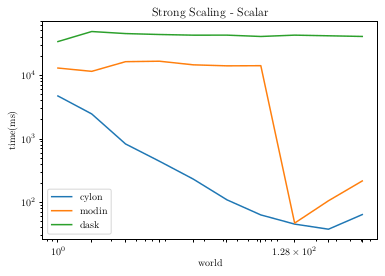

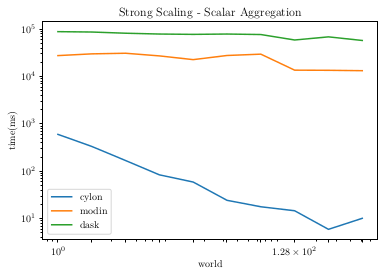

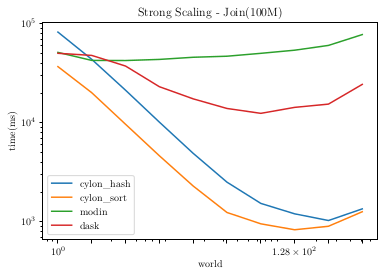

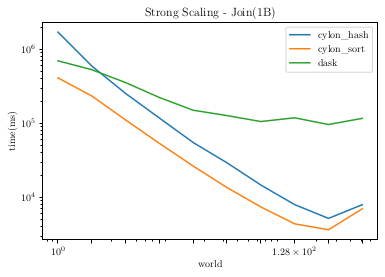

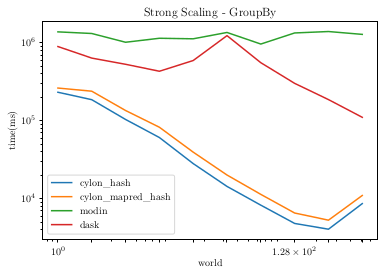

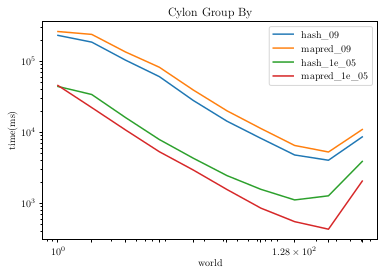

In [12]:
just_show = False

process_scalar('resultsgraphs/scalar.csv', 'resultsgraphs/modin_scalar.csv', 'resultsgraphs/dask_scalar.csv', 'Strong Scaling - Scalar', 'scalar.pgf', just_show)
process_scalar('resultsgraphs/scalar-agg.csv', 'resultsgraphs/modin_scalar_agg.csv', 'resultsgraphs/dask_scalar_agg.csv','Strong Scaling - Scalar Aggregation', 'scalar-agg.pgf', just_show)

process_join('resultsgraphs/join.csv', 'resultsgraphs/modin_join.csv', 'resultsgraphs/dask_join.csv','Strong Scaling - Join(100M)', 'join.pgf', len=100000000,just_show = just_show)
process_join('resultsgraphs/join.csv', 'resultsgraphs/modin_join.csv', 'resultsgraphs/dask_join.csv','Strong Scaling - Join(1B)', 'join.pgf', len=1000000000,exclude_modin = True, just_show = just_show)
process_groupby('resultsgraphs/groupby.csv', 'resultsgraphs/modin_groupby.csv', 'resultsgraphs/dask_groupby.csv','Strong Scaling - GroupBy', 'groupby.pgf', just_show)

process_groupby_cylon('resultsgraphs/groupby.csv', 'Cylon Group By', 'cylon_groupby.pgf', just_show)